#Introduction

#Research and Data Exploration

Add Imports i'll need

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from matplotlib.image import imread
from PIL import Image
import tensorflow as tf

it seems the other tensorflow imports are gving me issues so i'm going to install it to fix it

In [2]:
!pip install tensorflow

In [3]:
from tensorflow.keras import layers
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, AveragePooling2D,Flatten, Dense, Conv2D,MaxPool2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

i'm going to use kagglehub to get my dataset because it should be easier

In [4]:
import kagglehub

path = kagglehub.dataset_download("hayder17/breast-cancer-detection")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'breast-cancer-detection' dataset.
Path to dataset files: /kaggle/input/breast-cancer-detection


show me the folders to use

In [84]:
print(os.listdir(path))
img_size = 128
batch_size = 16
n_epochs = 25

['valid', 'test', 'train']


In [6]:
valid = path + "/valid/"
test = path + '/test/'
train = path + '/train/'

In [7]:
print(os.listdir(valid))
print(os.listdir(test))
print(os.listdir(train))

['0', '1']
['0', '1']
['0', '1']


in the dataset 0 = Benign and 1 = Malignant


In [8]:
labels = os.listdir(valid)

In [9]:
test_0 = test+"0/"

test_1 = test+"1/"

train_0 = train+"0/"

train_1 = train+"1/"

valid_0 = valid+"0/"

valid_1 = valid+"1/"

number of images in test

In [10]:
print(f'The Number of benign images in Test {len(os.listdir(test_0))}')
print(f'The Number of Malignant images in Test {len(os.listdir(test_1))}')
print(f'The Number of images in Test {len(os.listdir(test_0))+len(os.listdir(test_1))}')

The Number of benign images in Test 208
The Number of Malignant images in Test 128
The Number of images in Test 336


number of images in train

In [11]:
print(f'The Number of benign images in Train {len(os.listdir(train_0))}')
print(f'The Number of Malignant images in Train {len(os.listdir(train_1))}')
print(f'The Number of images in Train {len(os.listdir(train_0))+len(os.listdir(train_1))}')

The Number of benign images in Train 1569
The Number of Malignant images in Train 803
The Number of images in Train 2372


number of images in valid set

In [12]:
print(f'The Number of benign images in Valid {len(os.listdir(valid_0))}')
print(f'The Number of Malignant images in Valid {len(os.listdir(valid_1))}')
print(f'The Number of images in Valid {len(os.listdir(valid_0))+len(os.listdir(valid_1))}')

The Number of benign images in Valid 448
The Number of Malignant images in Valid 227
The Number of images in Valid 675


function to load images and make the images all the same size and smaller and also make the data an np array

In [13]:
img_size = 128
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data,dtype="object")

now i use my function on the dataset

In [14]:
train_ds = get_training_data(train)
test_ds = get_training_data(test)
valid_ds = get_training_data(valid)

In [15]:
print(f'Shape of training set{train_ds.shape}')
print(f'Shape of test set{test_ds.shape}')
print(f'Shape of validation set{valid_ds.shape}')

Shape of training set(2372, 2)
Shape of test set(336, 2)
Shape of validation set(675, 2)


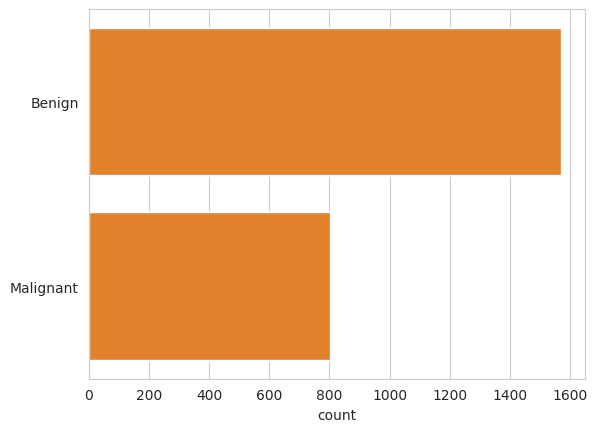

In [16]:
#create gird for training dataset
graphTrain = []

for i in train_ds:
  if(i[1]== 0):
    graphTrain.append("Benign")
  if(i[1]== 1):
    graphTrain.append("Malignant")
  sns.set_style('whitegrid')
  sns.countplot(graphTrain)

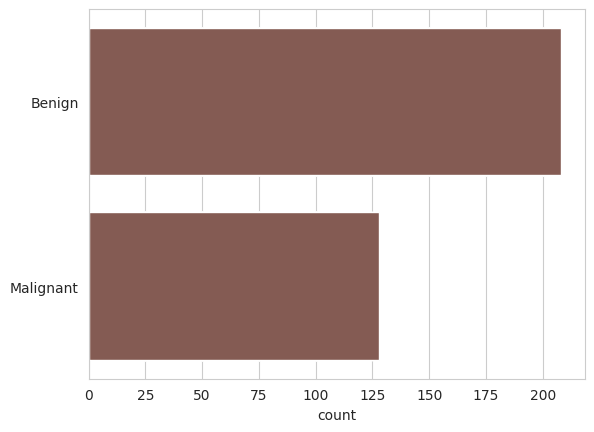

In [17]:
#create gird for test dataset
graphTrain = []

for i in test_ds:
  if(i[1]== 0):
    graphTrain.append("Benign")
  if(i[1]== 1):
    graphTrain.append("Malignant")
  sns.set_style('whitegrid')
  sns.countplot(graphTrain)

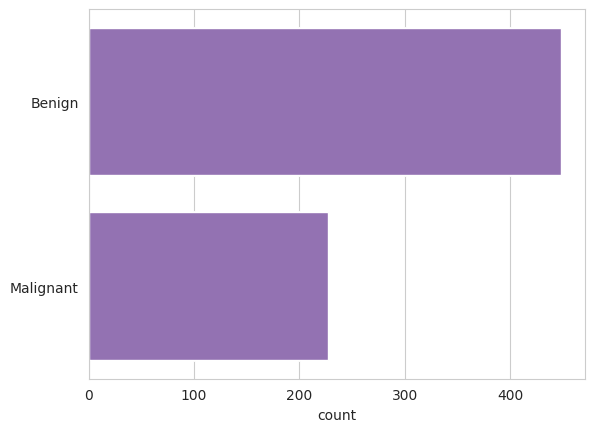

In [18]:
#create gird for valid dataset
graphTrain = []

for i in valid_ds:
  if(i[1]== 0):
    graphTrain.append("Benign")
  if(i[1]== 1):
    graphTrain.append("Malignant")
  sns.set_style('whitegrid')
  sns.countplot(graphTrain)

In [19]:
def show_images(number, benign=True):
    plt.figure(figsize=(12,12))
    if benign == True:
        for n in range(number):
            normal_img = os.listdir(train_0)[n]
            normal_img_address = train_0+normal_img
            normal_load = Image.open(normal_img_address)
            ax = plt.subplot(int(number/2),int(number/2),n+1)
            plt.imshow(normal_load, cmap ='gray')
            plt.title("Benign")
    else:
        for n in range(number):
            pneumonia_img =  os.listdir(train_1)[n]
            pneumonia_img_address = train_1+pneumonia_img
            pneumonia_load = Image.open(pneumonia_img_address)
            #cast nrows to integer
            ax = plt.subplot(int(number/2),int(number/2),n+1)
            plt.imshow(pneumonia_load, cmap ='gray')
            plt.title("Malignant")

    plt.axis("off")

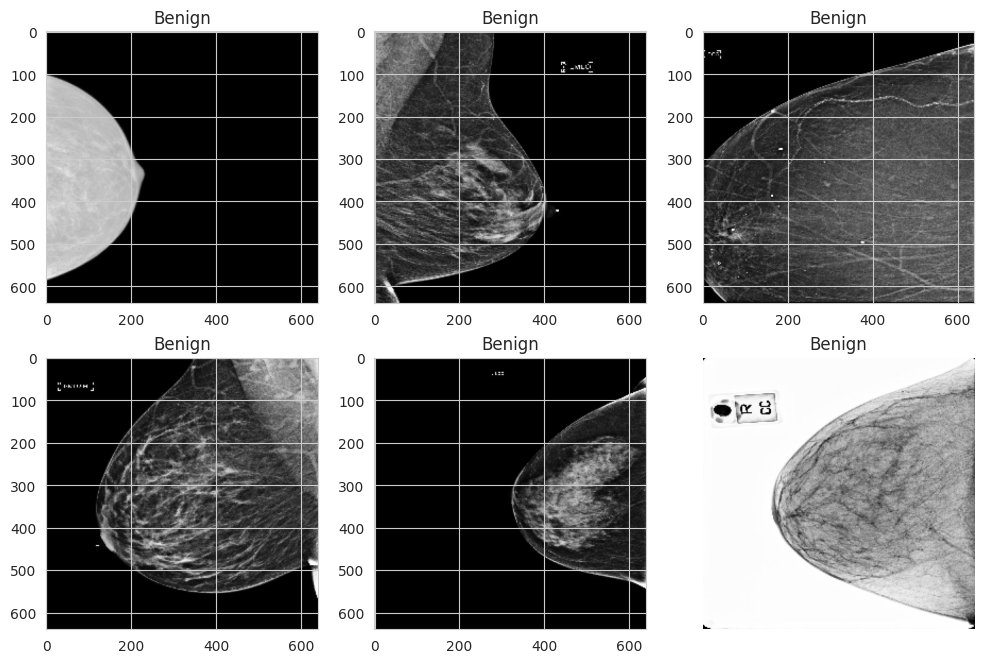

In [20]:
show_images(6)

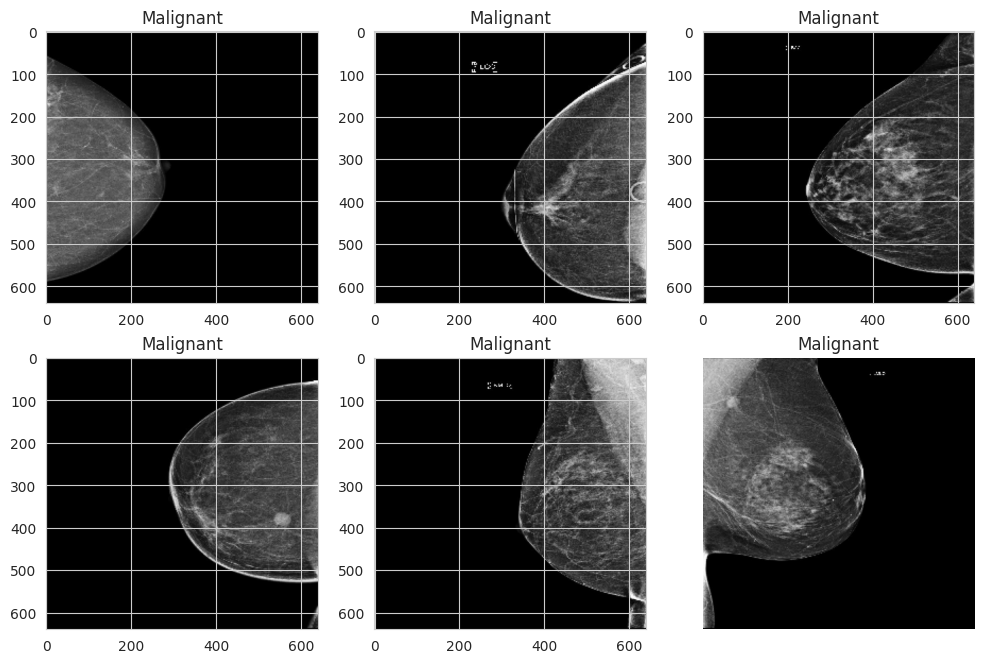

In [21]:
show_images(6,False)

I'm going to apply histogram equalization to improve visulisation

In [22]:
#!pip install scikit-image
from skimage import exposure

In [23]:
def equlize_hist_ (image):
  _image = np.asarray(image)
  image_eq = exposure.equalize_hist(_image)
  return image_eq

In [24]:
def expose_imgae(benign=True):
    if benign==True:
        # Choose normal random image: generate random number between 1 and  the number of normal images in the training set
        random_img_ind= np.random.randint(0,len(os.listdir(train_0)))
        # image file name
        img_expose_name = os.listdir(train_0)[random_img_ind]

        # path to the image
        img_expose_address = train_0+img_expose_name

        # load mage
        img_expose = Image.open(img_expose_address)
        img = np.asarray(img_expose)
        image_eq = equlize_hist_(img)
        figure1 = plt.figure(figsize= (16,16))
        img_1 = figure1.add_subplot(1,2,1)
        img_plot = plt.imshow(img, cmap = 'gray')
        img_1.set_title('benign')
        plt.axis("off")

        img2 = figure1.add_subplot(1, 2, 2)
        img_plot = plt.imshow(image_eq, cmap = 'gray')
        img2.set_title('benign after HE')
        plt.axis("off")
    else:
        # Choose normal random image: generate random number between 1 and  the number of normal images in the training set
        random_img_ind= np.random.randint(0,len(os.listdir(train_1)))
        # image file name
        img_expose_name = os.listdir(train_1)[random_img_ind]

        # path to the image
        img_expose_address = train_1+img_expose_name

        # load mage
        img_expose = Image.open(img_expose_address)
        img = np.asarray(img_expose)
        image_eq = equlize_hist_(img)
        figure1 = plt.figure(figsize= (16,16))
        img_1 = figure1.add_subplot(1,2,1)
        img_plot = plt.imshow(img, cmap = 'gray')
        img_1.set_title('Malignant')
        plt.axis("off")

        img2 = figure1.add_subplot(1, 2, 2)
        img_plot = plt.imshow(image_eq, cmap = 'gray')
        img2.set_title('Malignant after HE')
        plt.axis("off")


lets show a benign image and a Malignant image

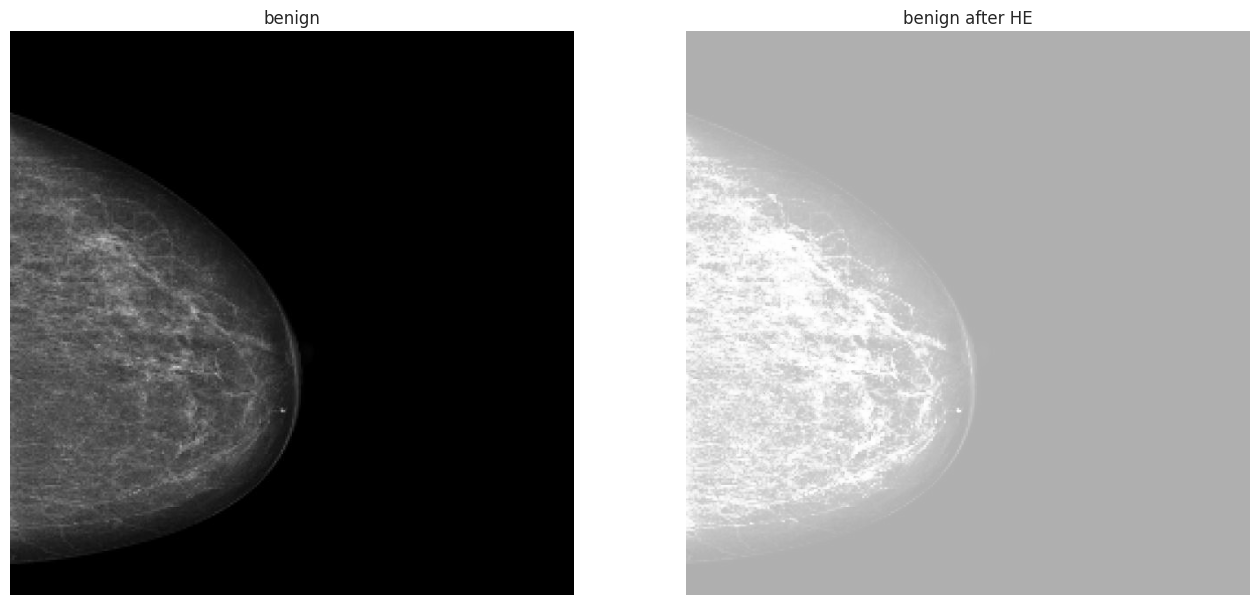

In [25]:
expose_imgae()

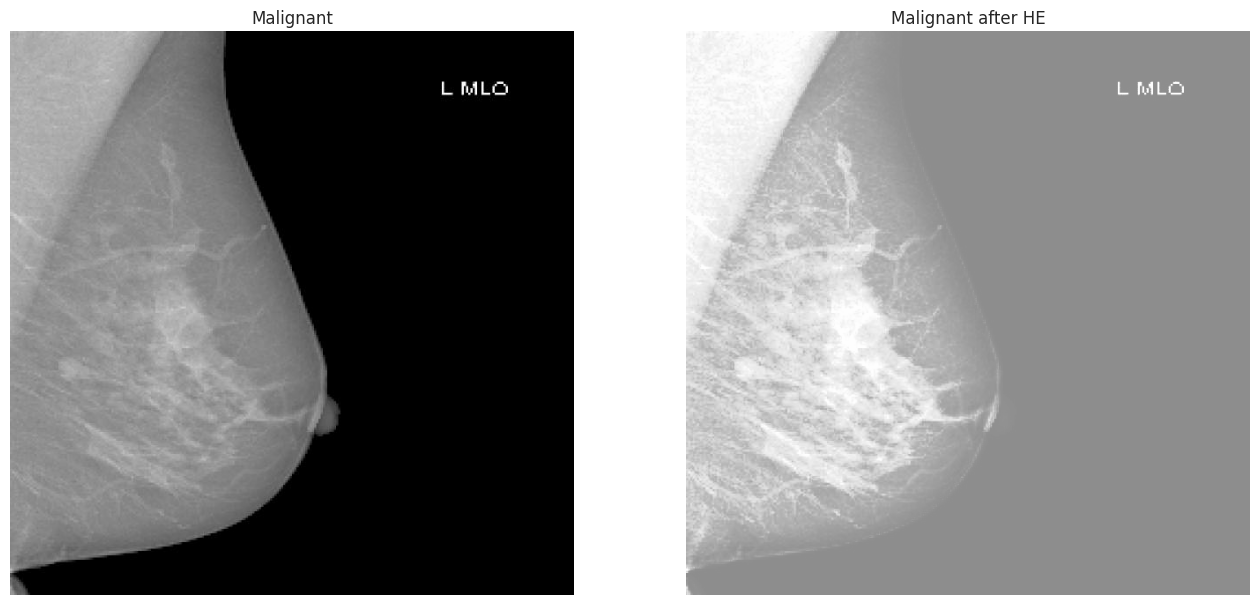

In [26]:
expose_imgae(False)

#Baseline Model

I need to Build a CNN

In [78]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train_ds:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test_ds:
    x_test.append(feature)
    y_test.append(label)

for feature, label in valid_ds:
    x_val.append(feature)
    y_val.append(label)

In [79]:
print(f'Number of images in the training set is {len(x_train)}')

Number of images in the training set is 2372


In [80]:


x_train = np.array(x_train) / 255.0
x_val = np.array(x_val) / 255.0
x_test = np.array(x_test) / 255.0

In [85]:
x_train = x_train.reshape(-1, img_size, img_size, 3)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 3)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 3)
y_test = np.array(y_test)

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

datagen = ImageDataGenerator(

      featurewise_center=False,
      samplewise_center=False,
      featurewise_std_normalization=False,
      samplewise_std_normalization=False,
      zca_whitening=False,
      rotation_range = 30,
      zoom_range = 0.2,

      width_shift_range = 0.1,
      height_shift_range = 0.1,
      horizontal_flip = True,
      vertical_flip=False)

datagen.fit(x_train)

In [33]:
# Model setup
model = Sequential()
model.add(Conv2D(32, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Conv2D(64, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Conv2D(64, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Conv2D(128, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Conv2D(256, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1, activation = 'sigmoid'))

model.compile(
              optimizer = 'rmsprop', loss = 'binary_crossentropy',
              metrics = ['accuracy']
              )

In [34]:
# model summary (see the number of trainable parameters)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 952,065 (3.63 MB)

 Trainable params: 950,977 (3.63 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [36]:
total = len(os.listdir(train_1)) + len(os.listdir(train_0))
neg = len(os.listdir(train_1))
pos = len(os.listdir(train_0))

weight_for_0 = 1 /neg * (total/2.0)
weight_for_1 = 1/pos *(total/2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}
class_weight

{0: 1.4769613947696139, 1: 0.7558954748247291}

In [37]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2, verbose = 1, factor = 0.3, min_lr = 0.000001)

In [92]:
# Start training the model
history = model.fit(datagen.flow(x_train, y_train, batch_size = batch_size),
                    epochs = n_epochs, validation_data = datagen.flow(x_val, y_val),
                    callbacks = [learning_rate_reduction], class_weight = class_weight)

Epoch 1/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - accuracy: 0.6463 - loss: 0.6287 - val_accuracy: 0.6622 - val_loss: 0.6386 - learning_rate: 1.0000e-06
Epoch 2/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 0.6695 - loss: 0.6128 - val_accuracy: 0.6637 - val_loss: 0.6298 - learning_rate: 1.0000e-06
Epoch 3/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.6652 - loss: 0.6162 - val_accuracy: 0.6622 - val_loss: 0.6258 - learning_rate: 1.0000e-06
Epoch 4/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.6702 - loss: 0.6036 - val_accuracy: 0.6622 - val_loss: 0.6345 - learning_rate: 1.0000e-06
Epoch 5/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 15s 100ms/step - accuracy: 0.6724 - loss: 0.5978 - val_accuracy: 0.6622 - val_loss: 0.6378 - learning_rate: 1.0000e-06
Epoch 6/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - accuracy: 0.6587 - loss: 0.6083 - val_accuracy: 0.6637 - val_loss: 0.6239 - learning_rate: 1.0000e-06
Epoch 7/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/st

<Axes: >

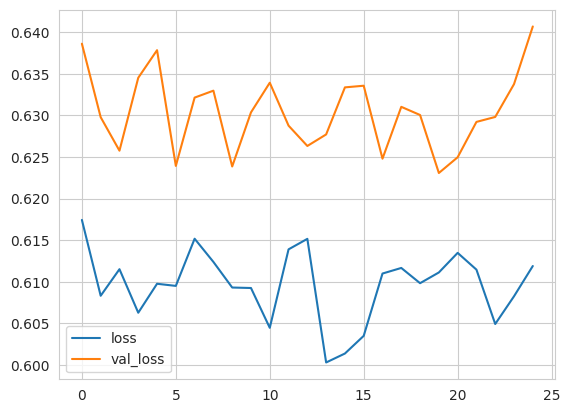

In [93]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()

<Axes: >

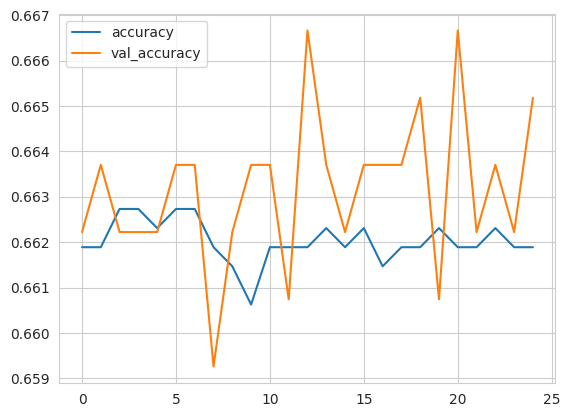

In [94]:
losses[['accuracy','val_accuracy']].plot()

In [95]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8626 - loss: 0.4410
Loss of the model is -  0.689116895198822
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8626 - loss: 0.4410
Accuracy of the model is -  61.90476417541504 %


In [98]:
predictions=model.predict(x_test)
pred_labels= np.where(predictions>0.4, 1, 0)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [99]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, pred_labels, target_names = ['Benign (Class 0)','Malignant (Class 1)']))

                     precision    recall  f1-score   support

   Benign (Class 0)       0.63      0.98      0.76       208
Malignant (Class 1)       0.58      0.05      0.10       128

           accuracy                           0.62       336
          macro avg       0.60      0.52      0.43       336
       weighted avg       0.61      0.62      0.51       336



<Axes: >

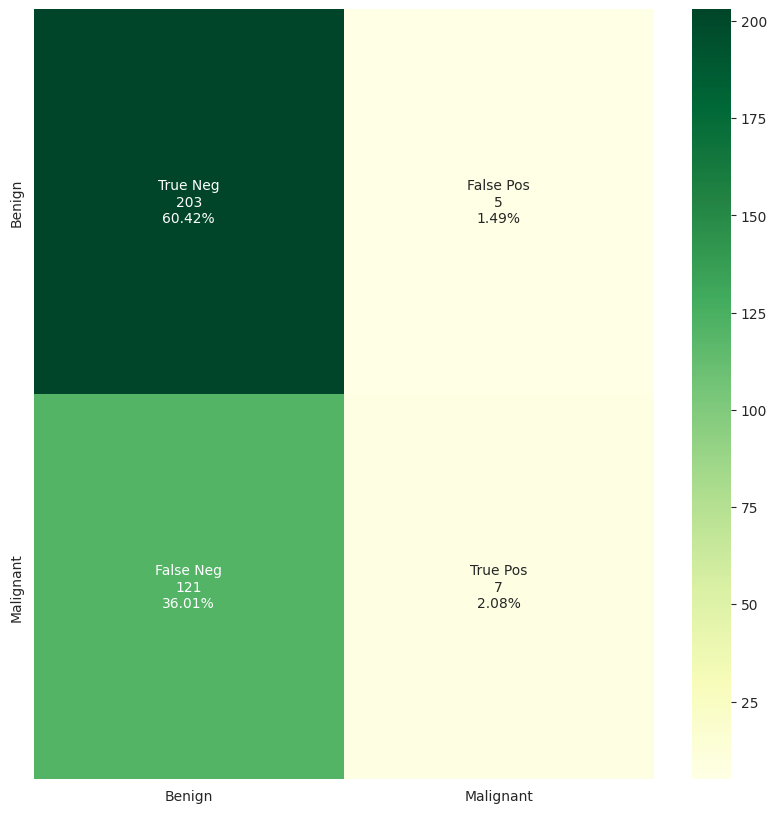

In [100]:

cf_matrix = confusion_matrix(y_test, pred_labels)
plt.figure(figsize = (10,10))
classes = ['Benign','Malignant']
labels = ['TN','FP','FN','TP']
labels = np.asarray(labels).reshape(2,2)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap= "YlGn" ,
            xticklabels = classes,yticklabels = classes
           )

In [101]:

results = pd.DataFrame({'Actual':y_test,'Predicted':pred_labels.flatten()})

incorrect_df = results[results.Actual!=results.Predicted]
incorrect_df.head()

,Actual,Predicted
0,0,1
61,0,1
114,0,1
177,0,1
185,0,1


In [102]:

print(f'Accuracy is {round((results.shape[0]-incorrect_df.shape[0])/results.shape[0],2)*100} %')

Accuracy is 62.0 %


In [103]:

correct = np.nonzero(pred_labels == y_test)[0]
incorrect = np.nonzero(pred_labels != y_test)[0]

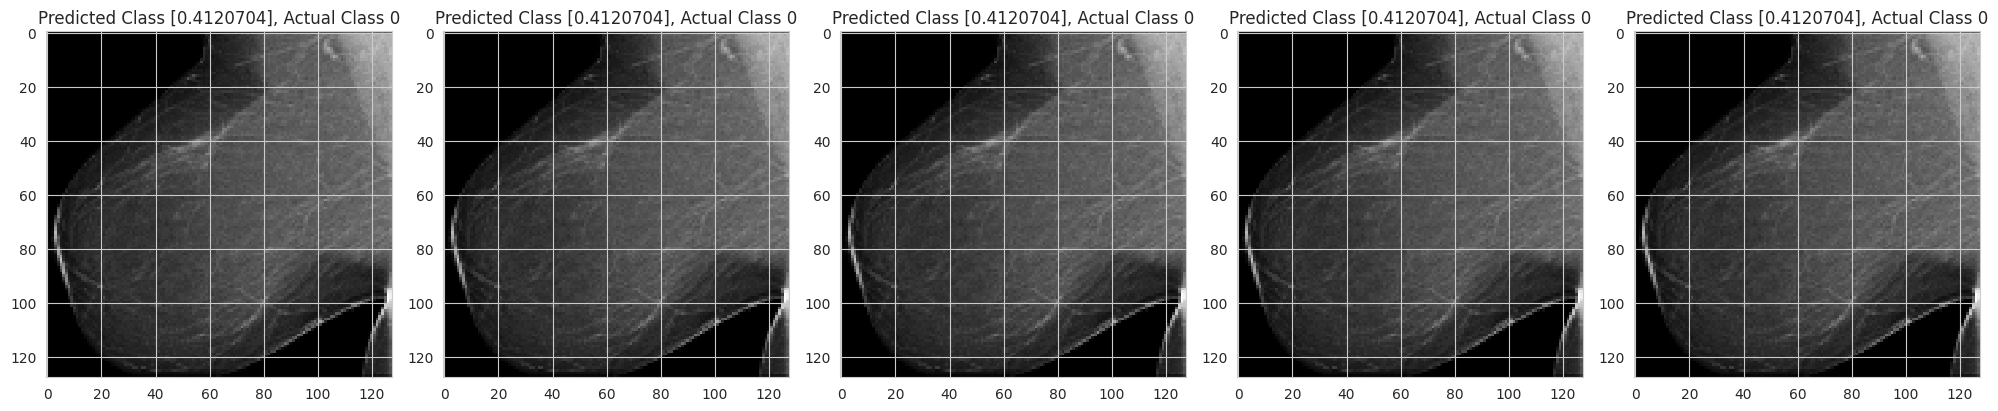

In [104]:
i = 0
figure = plt.figure(figsize= (20,20))
for c in correct[:5]:
    ax = plt.subplot(5,5,i+1)
    plt.imshow(x_test[c].reshape(img_size,img_size,3), cmap="gray", interpolation='none')
    plt.title("Predicted Class {}, Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

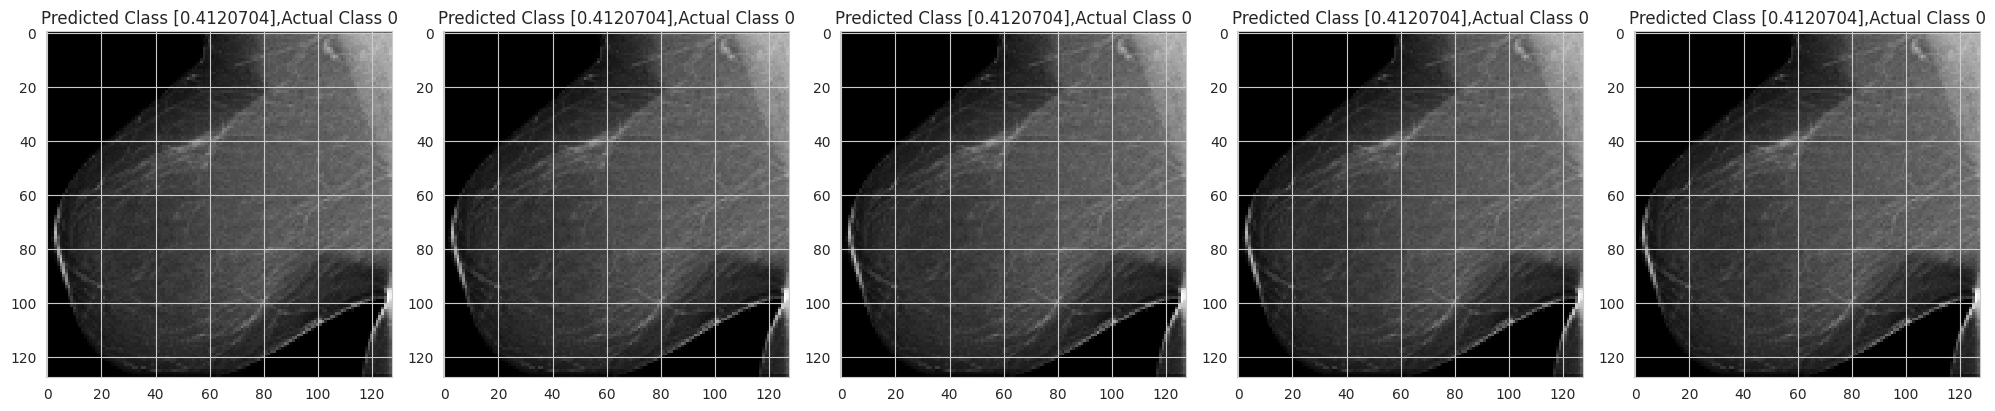

In [105]:
i = 0
figure = plt.figure(figsize= (20,20))
for c in incorrect[:5]:
    ax = plt.subplot(5,5,i+1)
    plt.imshow(x_test[c].reshape(img_size,img_size,3), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

#Solution Improvement

#Conclusion and Future Direction